In [44]:
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
import cv2
from keras.models import Sequential
from keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense, Dropout
from keras.models import Model, load_model
from keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import imutils
import numpy as np
import os 
from tqdm import tqdm
import matplotlib.pyplot as plt

In [30]:
model = Sequential([
    Conv2D(100, (3,3), activation='relu', input_shape=(150,150,3)),
    MaxPooling2D(2,2),
    
    Conv2D(100, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    
    Flatten(),
    Dropout(0.5),
    Dense(50, activation='relu'),
    Dense(2, activation='softmax')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [31]:
TRAINING_DIR = "./mask_detection/train"
train_datagen = ImageDataGenerator(rescale=1.0/255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(TRAINING_DIR, 
                                                    batch_size=10, 
                                                    target_size=(150, 150))
VALIDATION_DIR = "./mask_detection/test"
validation_datagen = ImageDataGenerator(rescale=1.0/255)

validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR, 
                                                         batch_size=10, 
                                                         target_size=(150, 150))

Found 1265 images belonging to 2 classes.
Found 194 images belonging to 2 classes.


In [46]:
CATEGORIES = ['with_mask','without_mask']

IMG_SIZE = 150
train_data = []

for c in CATEGORIES:
    path = os.path.join(TRAINING_DIR, c)
    class_num = CATEGORIES.index(c)

    for img in  tqdm(os.listdir(path)):
        try:
            img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_COLOR)
            img_resized = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
            train_data.append([img_resized, class_num])
        except Exception as e:
            pass

print(len(train_data))

100%|███████████████████████████████████████████████████████████████████████████████| 611/611 [00:02<00:00, 242.86it/s]

1265


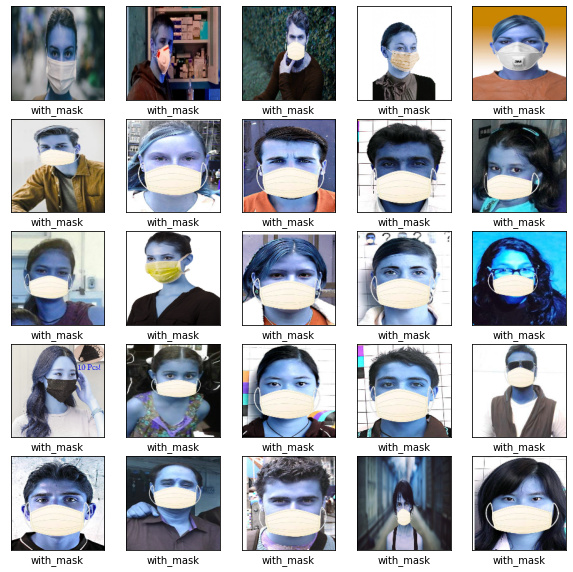

In [49]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(train_data[i][0])
    plt.xlabel(CATEGORIES[train_data[i][1]])
plt.show()

In [52]:
checkpoint = ModelCheckpoint('model2-{epoch:03d}.model',monitor='val_loss',verbose=0,save_best_only=True,mode='auto')

In [53]:
try:
    history = model.fit_generator(train_generator,
                                  epochs=10,
                                  validation_data=validation_generator,
                                  callbacks=[checkpoint])
except Exception as e:
    print(e)

Epoch 1/10
127/127 [==============================] - 74s 584ms/step - loss: 0.3389 - acc: 0.8632 - val_loss: 0.2528 - val_acc: 0.8814
Epoch 2/10
127/127 [==============================] - 69s 544ms/step - loss: 0.3427 - acc: 0.8672 - val_loss: 0.1654 - val_acc: 0.9021
Epoch 3/10
127/127 [==============================] - 75s 593ms/step - loss: 0.3039 - acc: 0.8901 - val_loss: 0.1428 - val_acc: 0.9330
Epoch 4/10
127/127 [==============================] - 71s 560ms/step - loss: 0.2495 - acc: 0.9036 - val_loss: 0.1087 - val_acc: 0.9485
Epoch 5/10
127/127 [==============================] - 69s 543ms/step - loss: 0.2358 - acc: 0.9154 - val_loss: 0.1105 - val_acc: 0.9536
Epoch 6/10
127/127 [==============================] - 70s 552ms/step - loss: 0.2203 - acc: 0.9107 - val_loss: 0.1152 - val_acc: 0.9485
Epoch 7/10
127/127 [==============================] - 79s 621ms/step - loss: 0.2096 - acc: 0.9241 - val_loss: 0.1276 - val_acc: 0.9278
Epoch 8/10
127/127 [==============================] - 9

In [62]:
import cv2
import numpy as np
from keras.models import load_model
model=load_model("./model2-002.model")

results={0:'without mask',1:'mask'}
GR_dict={0:(0,0,255),1:(0,255,0)}

rect_size = 4
cap = cv2.VideoCapture(0)


haarcascade = cv2.CascadeClassifier('./mask_detection/haarcascade_frontalface_default.xml')

while True:
    rval, im = cap.read()
    im=cv2.flip(im,1,1)
    #print(im)

    rerect_size = cv2.resize(im,(im.shape[1] // rect_size, im.shape[0] // rect_size))
    faces = haarcascade.detectMultiScale(rerect_size)
    for f in faces:
        (x, y, w, h) = [v * rect_size for v in f] 
        
        face_img = im[y:y+h, x:x+w]
        rerect_sized=cv2.resize(face_img,(150,150))
        normalized=rerect_sized/255.0
        reshaped=np.reshape(normalized,(1,150,150,3))
        reshaped = np.vstack([reshaped])
        result=model.predict(reshaped)

        
        label=np.argmax(result,axis=1)[0]
      
        cv2.rectangle(im,(x,y),(x+w,y+h),GR_dict[label],2)
        cv2.rectangle(im,(x,y-40),(x+w,y),GR_dict[label],-1)
        cv2.putText(im, results[label], (x, y-10),cv2.FONT_HERSHEY_SIMPLEX,0.8,(255,255,255),2)

    cv2.imshow('Live',im)
    key = cv2.waitKey(10)
    
    if key == 27: 
        break

    #if cv2.waitKey(1) & 0xFF ==ord('q'):
    #    break

cap.release()

cv2.destroyAllWindows()

In [63]:
cap.release()

cv2.destroyAllWindows()